# Springboard Apps project - Tier 3 - Complete

## Importing the libraries
In this case we are going to import pandas, numpy, scipy, random and matplotlib.pyplot

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
pd.set_option('display.float_format', lambda v: f"{v:,.4f}")

## Stage 1 -  Sourcing and loading data

### 1a. Source and load the data
We'll use the datasets you provided (already uploaded to this environment).

In [33]:
google_path = r"C:\Springboard\Python Stats in EDA\11.3 Hypthesis Testing\1585016537_Apps_Case_Study\Project Files\googleplaystore.csv"
apple_path  = r"C:\Springboard\Python Stats in EDA\11.3 Hypthesis Testing\1585016537_Apps_Case_Study\Project Files\AppleStore.csv"

Google = pd.read_csv(google_path)
Apple  = pd.read_csv(apple_path)

Google.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1000,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9000,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7000,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


### 1b. Pick the columns we'll work with

From the documentation of these datasets, we focus on:
- **Google:** `Category`, `Rating`, `Reviews`, `Price`
- **Apple:** `prime_genre`, `user_rating`, `rating_count_tot`, `price`

In [34]:
g_cols = ['Category','Rating','Reviews','Price']
a_cols = ['prime_genre','user_rating','rating_count_tot','price']

Google_sub = Google[g_cols].copy()
Apple_sub  = Apple[a_cols].copy()

Google_sub.head(3)

,Category,Rating,Reviews,Price
0,ART_AND_DESIGN,4.1000,159,0
1,ART_AND_DESIGN,3.9000,967,0
2,ART_AND_DESIGN,4.7000,87510,0


### 1c. Subsetting accordingly

In [6]:
Apple_sub.head(3)

,prime_genre,user_rating,rating_count_tot,price
0,Games,4.0000,21292,3.9900
1,Productivity,4.0000,161065,0.0000
2,Weather,3.5000,188583,0.0000


## Stage 2 -  Cleaning, transforming and visualizing

### 2a. Check the data types for both Apple and Google, and fix them

In [7]:
Apple_sub.dtypes

prime_genre          object
user_rating         float64
rating_count_tot      int64
price               float64
dtype: object

This is looking healthy. But what about our Google data frame?

In [8]:
Google_sub.dtypes

Category     object
Rating      float64
Reviews      object
Price        object
dtype: object

Weird. The data type for the column 'Price' is 'object', not a numeric type. Let's investigate the unique values of this column.

In [9]:
Google_sub['Price'].astype(str).unique()[:20]

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99'], dtype=object)

Aha! We may have a couple of issues:
- Some entries carry a **dollar symbol** (e.g., `$2.99`).
- Rare, malformed values can exist (historically `'Everyone'` showed up in some distributions).

Let's check if any rows have the price value `'Everyone'`.

In [10]:
bad_rows = Google_sub[Google_sub['Price'].astype(str).eq('Everyone')]
bad_rows

,Category,Rating,Reviews,Price
10472,1.9,19.0000,3.0M,Everyone


Thankfully, if present it's typically just one row. Let's eliminate it (no-ops if none present).

In [11]:
Google_sub = Google_sub[~Google_sub['Price'].astype(str).eq('Everyone')].copy()
Google_sub.shape

(10840, 4)

Our second problem remains: dollar symbols. Let's strip them and convert to numeric.

In [12]:
# Clean Google price
Google_sub['Price'] = (
    Google_sub['Price']
    .astype(str)
    .str.replace('$','', regex=False)
    .replace('Free', '0', regex=False)  # sometimes present
)
Google_sub['Price'] = pd.to_numeric(Google_sub['Price'], errors='coerce')

# Ratings & Reviews to numeric
Google_sub['Rating']  = pd.to_numeric(Google_sub['Rating'], errors='coerce')
Google_sub['Reviews'] = pd.to_numeric(Google_sub['Reviews'], errors='coerce')

Google_sub.dtypes

Category     object
Rating      float64
Reviews       int64
Price       float64
dtype: object

### 2b. Make the two datasets comparable by renaming and adding a `platform` column

In [13]:
Google_sub = Google_sub.rename(columns={'Category':'genre','Rating':'rating','Reviews':'rating_count_tot','Price':'price'})
Apple_sub  = Apple_sub.rename(columns={'prime_genre':'genre','user_rating':'rating'})

Google_sub['platform'] = 'Google'
Apple_sub['platform']  = 'Apple'

Google_sub.head(2), Apple_sub.head(2)

(            genre  rating  rating_count_tot  price platform
 0  ART_AND_DESIGN  4.1000               159 0.0000   Google
 1  ART_AND_DESIGN  3.9000               967 0.0000   Google,
           genre  rating  rating_count_tot  price platform
 0         Games  4.0000             21292 3.9900    Apple
 1  Productivity  4.0000            161065 0.0000    Apple)

### 2c. Concatenate into a single dataframe

In [15]:
apps = pd.concat([Apple_sub[['genre','rating','rating_count_tot','price','platform']].copy(),
                  Google_sub[['genre','rating','rating_count_tot','price','platform']].copy()],
                 ignore_index=True)
apps.shape, apps.head(3)

((18037, 5),
           genre  rating  rating_count_tot  price platform
 0         Games  4.0000             21292 3.9900    Apple
 1  Productivity  4.0000            161065 0.0000    Apple
 2       Weather  3.5000            188583 0.0000    Apple)

### 2d. Drop rows without ratings or reviews

In [16]:
apps_before = apps.shape[0]
apps = apps.dropna(subset=['rating']).copy()
apps = apps[apps['rating_count_tot'].notna()].copy()
apps_after = apps.shape[0]
apps_before, apps_after

(18037, 16563)

### 2e. Summary by platform

In [17]:
summary = apps.groupby('platform')['rating'].agg(['count','mean','median','std']).round(3)
summary

,count,mean,median,std
platform,,,,
Apple,7197,3.5270,4.0000,1.5180
Google,9366,4.1920,4.3000,0.5150


### 2f. Visual comparison: histograms of ratings by platform

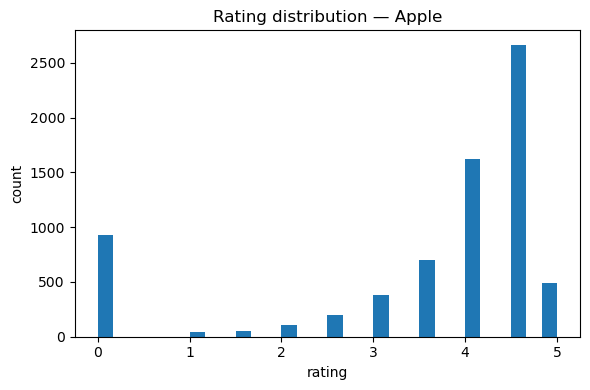

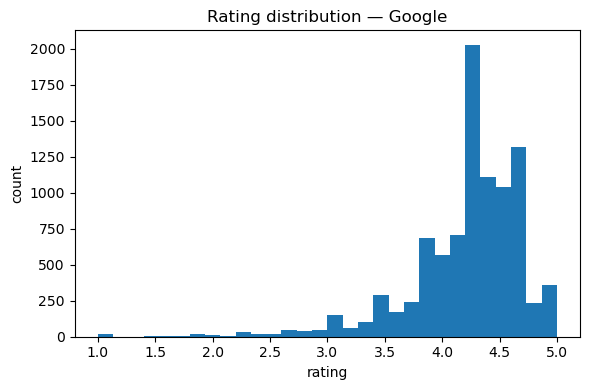

In [18]:
for plat in apps['platform'].unique():
    s = apps.loc[apps['platform']==plat, 'rating'].dropna()
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=30)
    plt.title(f'Rating distribution — {plat}')
    plt.xlabel('rating'); plt.ylabel('count')
    plt.tight_layout()
    plt.show()

The analytical and visual summaries suggest possible differences; we'll test statistically next.

## Stage 3 - Modelling

### 3a. Hypothesis formulation

We test whether the **mean rating** differs between Apple and Google apps.
- **H₀:** μ_Apple − μ_Google = 0  
- **H₁:** μ_Apple − μ_Google ≠ 0

### 3b. Getting the distribution of the data

In [19]:
apple_r = apps.loc[apps['platform']=='Apple','rating'].dropna().values
google_r = apps.loc[apps['platform']=='Google','rating'].dropna().values

# Normality checks (D’Agostino-Pearson)
apple_normal = stats.normaltest(apple_r)
google_normal = stats.normaltest(google_r)
apple_normal, google_normal

(NormaltestResult(statistic=1671.3755748541048, pvalue=0.0),
 NormaltestResult(statistic=3678.6157187516856, pvalue=0.0))

Normality often fails for ratings (bounded on [0,5]); we'll use a **permutation test** for the difference in means.

### 3c. Permutation test setup

In [20]:
rng = np.random.default_rng(42)
n_perms = 10000

obs_diff = apple_r.mean() - google_r.mean()

combined = np.concatenate([apple_r, google_r])
nA = len(apple_r)

diffs = np.empty(n_perms)
for i in range(n_perms):
    perm = rng.permutation(combined)
    A = perm[:nA]
    B = perm[nA:]
    diffs[i] = A.mean() - B.mean()

obs_diff, diffs[:5]

(-0.6648017444808714,
 array([-0.00652872, -0.01132018, -0.00365384, -0.01257333,  0.02406292]))

### 3d. Visualize the null distribution and mark the observed difference

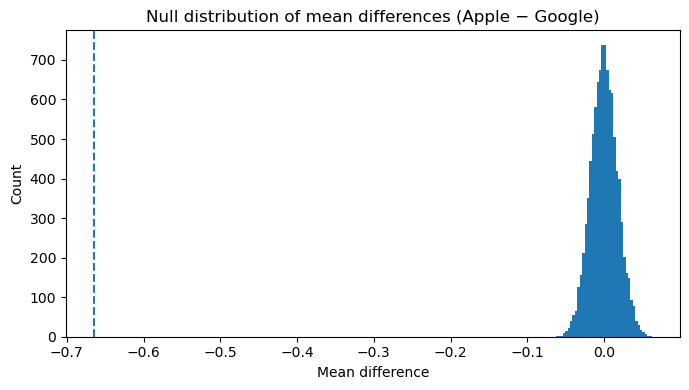

In [21]:
plt.figure(figsize=(7,4))
plt.hist(diffs, bins=40)
plt.axvline(obs_diff, linestyle='--')
plt.title('Null distribution of mean differences (Apple − Google)')
plt.xlabel('Mean difference'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

### 3e. Two-sided p-value

In [22]:
p_val = (np.abs(diffs) >= np.abs(obs_diff)).mean()
obs_diff, p_val

(-0.6648017444808714, 0.0)

## Stage 4 -  Evaluating and concluding

### 4a. What is our conclusion?

In [23]:
print(f"Observed mean difference (Apple − Google) = {obs_diff:.4f}")
print(f"Permutation p-value (two-sided)          = {p_val:.4f}")
if p_val < 0.05:
    print("Conclusion: Reject H0 at α=0.05; evidence of a difference in mean ratings.")
else:
    print("Conclusion: Fail to reject H0 at α=0.05; no strong evidence of a difference.")

Observed mean difference (Apple − Google) = -0.6648
Permutation p-value (two-sided)          = 0.0000
Conclusion: Reject H0 at α=0.05; evidence of a difference in mean ratings.


### 4b. What is our decision?

We compare the p-value to α=0.05. If p ≤ 0.05, we **reject** H₀ and conclude there is a statistically significant difference. Otherwise, we **fail to reject** H₀.

### 4c. Other statistical tests, and next steps

Because ratings are bounded and not perfectly normal, the permutation test is a robust choice.
For follow-ups:
- Compare medians via **Mann–Whitney U** test.
- Model rating as a function of `genre`, `price`, and `rating_count_tot` with linear/robust regression.
- Incorporate text features from app descriptions to improve explanatory power.